# Project: Understanding the Intrinsic and Extrinsic Value of Options Premium
The premium that a buyer of an American options contract pays $\mathcal{P}$ is composed of two components, the `intrinsic` value $\mathcal{P}_{int}$ and `extrinsic` value $\mathcal{P}_{ext}$:
* The `intrinsic` value $\mathcal{P}_{int}$ of the options premium is the value of the option contract if exercised now, i.e., it is the current payoff of the contract. Thus, the intrinsic value will be a function of the scaled strike price $K/S_{\circ}$. However, the intrinsic value will not be a _direct_ function of the time to expiration.
* The `extrinsic` value $\mathcal{P}_{ext}$ is the difference between the current premium $\mathcal{P}$ and the intrinsic value, i.e., $\mathcal{P}_{ext} = \mathcal{P} - \mathcal{P}_{int}$. As the days to expiration `DTE` of the options contract approaches zero, the `extrinsic` value approaches zero, i.e., $\lim_{DTE\rightarrow{0}}\,\mathcal{P}_{ext}\rightarrow{0}$. Thus, the extrinsic value will be a function of the scaled strike price $K/S_{\circ}$ (through the intrinsic value) and the days to expiration (through the premium).

## Learning tasks
This project aims to familiarize students with understanding option contracts `intrinsic` and `extrinsic` values and to help them consider what factors control each.

* `Prerequisites`: load and interrogate the options chains for different values of the days to expiration (DTE) parameter for an example underlying ticker, in this case, [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) with the ticker symbol `AMD.`
* __Task 1__: Compute the Intrinsic and Extrinsic values of American put contacts
* __Task 2__: Compare the Extrinsic value of Short- and Long-dated American put contracts
* __Task 3__: Compute the Intrinsic and Extrinsic values of American call contacts

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`


## Prerequisites
Load the options chain dataset using the `MyOptionsChainDataSet()` function. This function returns the pricing data as a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) with `keys` holding the number of days to expiration `DTE::Int64` and `values` being a [Vector](https://docs.julialang.org/en/v1/base/arrays/#Base.Vector-Tuple{UndefInitializer,%20Any}) of multilevel dictionaries. We'll store the options contract price data in the `dataset` variable.
* In this project, we'll use options pricing data for [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) as the underlying asset. The `dataset` variable holds pricing information for `call` and `put` contracts. Each contract has a different strike price. In addition to the contract price, there is additional information about the underlying asset and contract. 
* For any given `DTE` key, the price data is organized as a `Vector{Dict{String, Any}},` where each element in the vector is a dictionary with the `keys`: `day,` `details,` `last_quote,` `last_trade,` `underlying_asset,` `open_interest` and `break_even_price.` Each key (except for the `open_interest` and `break_even_price` keys) points to another dictionary.
* Finally, we populate lists of `call` and `put` options in the `list_of_put_options_chains` and `list_of_call_options_chains` variables, which have the type `Dict{Int64, DataFrame},` using the `search(...)` function.

In [5]:
dataset = MyOptionsChainDataSet();

Let's populate a list of `put` and `call` options written against `AMD`  whose strike price is between `60` and `180` USD/share. We store these lists in the `list_of_put_options_chains` and `list_of_call_options_chains,` which have the type `Dict{Int64, DataFrame}.`

* __Put options__: `Unhide` the code block below to see how we populate a list of `put` options with strike prices between `60.0 ≤ K ≤ 180.0` in the `list_of_put_options_chains` variable

In [7]:
list_of_put_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin
            K = record["details"]["strike_price"]; # strike for this contract
            if (record["details"]["contract_type"] == "put" && 60.0 ≤ K ≤ 180.0)
                return true
            end
            return false
        end
    ) |> dataframe -> list_of_put_options_chains[dte_value] = dataframe;
end

* __Call options__: `Unhide` the code block below to see how we populate a list of `call` options with strike prices between `60.0 ≤ K ≤ 180.0` in the `list_of_call_options_chains` variable

In [9]:
list_of_call_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin
            K = record["details"]["strike_price"]; # strike for this contract
            if (record["details"]["contract_type"] == "call" && 60.0 ≤ K ≤ 180.0)
                return true
            end
            return false
        end
    ) |> dataframe -> list_of_call_options_chains[dte_value] = dataframe;
end

### Constants

In [11]:
Δt = (1/365);
T̂ = 39;
S₁ = 60.0;
S₂ = 180.0;
S = range(S₁, stop = S₂, step=1.0) |> collect;
number_of_prices = length(S);

## Task 1: Compute the Intrinsic and Extrinsic values of American put contacts
Fill me in

In [13]:
tmp_contract_list = list_of_put_options_chains[T̂]
number_of_contracts = nrow(tmp_contract_list);

Fill me in

In [15]:
put_data_dictionary = Dict{Float64, NamedTuple}();
for i ∈ 1:number_of_contracts
    K = tmp_contract_list[i,:strike];
    𝒫_ask = tmp_contract_list[i,:ask];
    𝒫_bid = tmp_contract_list[i,:bid];
    𝒫_mid = tmp_contract_list[i,:midpoint];
    Sₒ = tmp_contract_list[i,:underlying]

    # compute payoff (intrinsic) using short-cut syntax    
    payoff_array = build(MyAmericanPutContractModel, (
        K = K, sense = 1, copy = 1, DTE = T̂*Δt, IV = 0.1, premium = 𝒫_mid)) |> model -> model([Sₒ]);

    # capture the data
    data = (
        intrinsic = payoff_array[1,end],
        extrinsic_bid = (𝒫_bid - payoff_array[1,end]),
        extrinsic_ask = (𝒫_ask - payoff_array[1,end]),
        extrinsic_mid = (𝒫_mid - payoff_array[1,end]),
        premium_bid = 𝒫_bid,
        premium_ask = 𝒫_ask,
        premium_mid = 𝒫_mid,
        underlying = Sₒ
    );
    put_data_dictionary[K] = data;
end

### Visualize

In [52]:
put_strike_price_array = keys(put_data_dictionary) |> collect |> sort;
put_dataframe = DataFrame();
counter = 0;
skip = 1;
for K ∈ put_strike_price_array

    if (mod(counter,skip) == 0)
        data = put_data_dictionary[K];
        row_df = (
            K = K,
            scaled_K = (K/data.underlying),
            intrinsic = data.intrinsic,
            extrinsic_bid = data.extrinsic_bid,
            extrinsic_ask = data.extrinsic_ask,
            premium_bid = data.premium_bid,
            premium_ask = data.premium_ask,
            fraction_extrinsic_ask = (data.extrinsic_ask/data.premium_ask)*100,
            fraction_intrinsic_ask = (data.intrinsic/data.premium_ask)*100
        );
        push!(put_dataframe, row_df);
    end
    counter += 1;
end
put_dataframe;

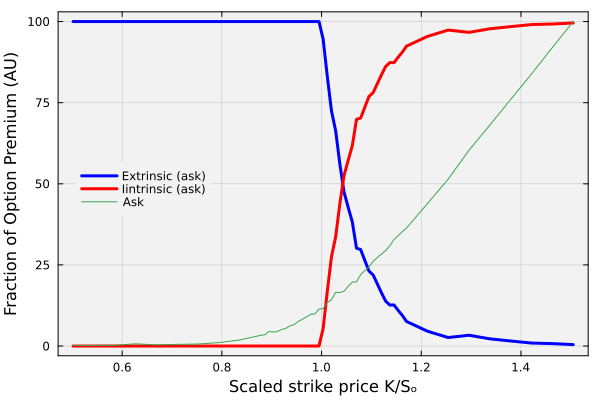

In [84]:
plot(put_dataframe[:,:scaled_K], put_dataframe[:,:fraction_extrinsic_ask], c=:blue, lw=3, label="Extrinsic (ask)", legend=:left, 
    bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
plot!(put_dataframe[:,:scaled_K], put_dataframe[:,:fraction_intrinsic_ask], c=:red, lw=3, label="Iintrinsic (ask)")
plot!(put_dataframe[:,:scaled_K], 100*(put_dataframe[:,:premium_ask]/(maximum(put_dataframe[:,:premium_ask]))), label="Ask")
xlabel!("Scaled strike price K/Sₒ", fontsize=18)
ylabel!("Fraction of Option Premium (AU)", fontsize=18)

## Task 2: Compare the Extrinsic value of Short- and Long-dated American put contracts
Fill me in.

## Task 3: Compute the Intrinsic and Extrinsic values of American call contacts
Fill me in.

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.